# DRINKING WATER
This notebook will be used to measure indicators for EDGI/EEW's 'state of the environment report.'
It is based on the NJ SDWA EJ notebook and the SOE report notebooks for other environmental media/pollutants.

In [1]:
# import libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Load Facilities Data

This section creates a dataframe of basic information about **active** water systems 


There is an option to filter for only Community Water Systems (or any other type) 

In [2]:
# Load facilities data into notebook
# this notebook uses a local copy
# download data here (under 'Drinking Water Data Downloads' heading): https://echo.epa.gov/tools/data-downloads#downloads 
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_PUB_WATER_SYSTEMS.csv"
sdwa_pws = pd.read_csv(path)

C:\Users\jenni\AppData\Local\Temp\ipykernel_43712\1812194723.py:5: DtypeWarning: Columns (8,11,32,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwa_pws = pd.read_csv(path)


In [3]:
# Filter to include only active systems
print("Number of systems total:",(len(sdwa_pws)))
sdwa_pws_active = sdwa_pws[sdwa_pws['PWS_ACTIVITY_CODE'] == 'A']
# total number of active PWS
print("Number of active systems:",(len(sdwa_pws_active)))

Number of systems total: 432695
Number of active systems: 143236


In [4]:
# summarize active PWS by type
sdwa_pws_active['PWS_TYPE_CODE'].value_counts()

PWS_TYPE_CODE
TNCWS     76732
CWS       49377
NTNCWS    17127
Name: count, dtype: int64

Filter to include only certain system types here >>>

In [5]:
#sdwa_pws_active = sdwa_pws_active[sdwa_pws_active['PWS_TYPE_CODE'] == 'CWS']
#print("Number of systems after filtering:",(len(sdwa_pws_active)))

# Load and Prep Violations Data

This section imports violations data (select columns), cleans up date fields, maps field codes, cleans up the state code field, and joins violations data to the facilities df

In [6]:
# Load Violations data into notebook
# File is too large to load in entirety so only load selected columns
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_VIOLATIONS_ENFORCEMENT.csv"
sdwa_viols = pd.read_csv(path,
                         usecols=['PWSID', 
                                  'VIOLATION_ID', 
                                  'VIOLATION_CODE',
                                  'VIOLATION_CATEGORY_CODE', 
                                  'IS_HEALTH_BASED_IND',
                                  'CONTAMINANT_CODE', 
                                  'RULE_CODE',
                                  'NON_COMPL_PER_BEGIN_DATE', 
                                  'NON_COMPL_PER_END_DATE',
                                  'VIOL_FIRST_REPORTED_DATE', 
                                  'ENFORCEMENT_ID',
                                  'ENFORCEMENT_DATE', 
                                  'ENFORCEMENT_ACTION_TYPE_CODE',
                                  'ENF_ACTION_CATEGORY', 
                                  'ENF_ORIGINATOR_CODE',
                                  'VIOLATION_STATUS'
                                 ],
                         parse_dates=['NON_COMPL_PER_BEGIN_DATE', 
                                      'NON_COMPL_PER_END_DATE', 
                                      'VIOL_FIRST_REPORTED_DATE', 
                                      'ENFORCEMENT_DATE'
                                     ]
                        )
print(len(sdwa_viols))

C:\Users\jenni\AppData\Local\Temp\ipykernel_43712\3807560092.py:4: DtypeWarning: Columns (2,9,10,11,12,20,31,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwa_viols = pd.read_csv(path,


14908621


## This section fixes some typing problems and data entry anomalies in the date fields

In [7]:
# Check date fields for null values
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))
print("Number of records with Null VIOL_FIRST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['VIOL_FIRST_REPORTED_DATE'].isna()]==True)))
#print("Number of records with Null VIOL_LAST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['VIOL_LAST_REPORTED_DATE'].isna()]==True)))
print("Number of records with Null ENFORCEMENT_DATE = " + str(len(sdwa_viols[sdwa_viols['ENFORCEMENT_DATE'].isna()]==True)))
#print("Number of records with Null ENF_FIRST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['ENF_FIRST_REPORTED_DATE'].isna()]==True)))
#print("Number of records with Null ENF_LAST_REPORTED_DATE = " + str(len(sdwa_viols[sdwa_viols['ENF_LAST_REPORTED_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 986459
Number of records with Null NON_COMPL_PER_END_DATE = 986459
Number of records with Null VIOL_FIRST_REPORTED_DATE = 986468
Number of records with Null ENFORCEMENT_DATE = 498147


In [8]:
# Check date field formats
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))
print(type(sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].loc[1]))
print(type(sdwa_viols['VIOL_FIRST_REPORTED_DATE'].loc[1]))
#print(type(sdwa_viols['VIOL_LAST_REPORTED_DATE'].loc[1]))
print(type(sdwa_viols['ENFORCEMENT_DATE'].loc[1]))
#print(type(sdwa_viols['ENF_FIRST_REPORTED_DATE'].loc[1]))
#print(type(sdwa_viols['ENF_LAST_REPORTED_DATE'].loc[1]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
# NON_COMPL_PER_END_DATE did not convert to timestamp
# why? some rows contain arrows; what do these mean?!?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE']=='--->']

,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,VIOL_FIRST_REPORTED_DATE,ENFORCEMENT_ID,ENFORCEMENT_DATE,ENFORCEMENT_ACTION_TYPE_CODE,ENF_ACTION_CATEGORY,ENF_ORIGINATOR_CODE
278,055294101,1010481,2024-01-17,--->,75,Other,N,7500.0,Addressed,410.0,2025-06-23,1795,2024-03-20,EFL,Formal,R
282,055294101,1010485,2024-01-11,--->,75,Other,N,7500.0,Addressed,410.0,2025-06-23,1795,2024-03-20,EFL,Formal,R
298,055294101,1010500,2021-12-01,--->,75,Other,N,7500.0,Addressed,410.0,2025-06-23,1795,2024-03-20,EFL,Formal,R
751,MS0320001,7103381,2021-10-08,--->,45,TT,Y,700.0,Unaddressed,140.0,2022-04-04,42,2021-12-27,SFJ,Informal,S
752,MS0320001,7103381,2021-10-08,--->,45,TT,Y,700.0,Unaddressed,140.0,2022-04-04,43,2021-12-27,SIE,Informal,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13922122,PA2520091,2313952,2023-01-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2023-03-16,NaN,NaT,NaN,NaN,NaN
13922137,PA2520091,2418135,2024-04-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2024-06-27,NaN,NaT,NaN,NaN,NaN
13922143,PA2520092,2331912,2023-07-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2023-09-19,NaN,NaT,NaN,NaN,NaN
13922147,PA2520092,2400760,2023-10-11,--->,75,Other,N,7500.0,Unaddressed,410.0,2024-02-23,NaN,NaT,NaN,NaN,NaN


In [10]:
# could the arrows indicate open violations but are incorrectly formatted? 
# data dictionary says open violations have NON_COMPL_PER_END_DATE = null
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 986459


In [11]:
# when did these null (open?) violations begin?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True]['NON_COMPL_PER_BEGIN_DATE']

13922162   NaT
13922163   NaT
13922164   NaT
13922165   NaT
13922166   NaT
            ..
14908616   NaT
14908617   NaT
14908618   NaT
14908619   NaT
14908620   NaT
Name: NON_COMPL_PER_BEGIN_DATE, Length: 986459, dtype: datetime64[ns]

In [12]:
# violations with NON_COMPL_PER_END_DATE = null (supposed to be open violations) do not seem to have begin dates either
# check how many records have null NON_COMPL_PER_END_DATE that have a valid NON_COMPL_PER_BEGIN_DATE
sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==False)]

,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,VIOL_FIRST_REPORTED_DATE,ENFORCEMENT_ID,ENFORCEMENT_DATE,ENFORCEMENT_ACTION_TYPE_CODE,ENF_ACTION_CATEGORY,ENF_ORIGINATOR_CODE


In [13]:
# that's an empty dataframe
# how many records have null NON_COMPL_PER_BEGIN_DATE & how many have null NON_COMPL_PER_END_DATE?
print("Number of records with Null NON_COMPL_PER_BEGIN_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()]==True)))
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_BEGIN_DATE = 986459
Number of records with Null NON_COMPL_PER_END_DATE = 986459


In [14]:
# same exact number of records 
# seems like the data coding for open violations is incorrect; instead of null they used arrows
# when do the violations with arrow notations for NON_COMPL_PER_END_DATE occur?
sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'] == '--->']['NON_COMPL_PER_BEGIN_DATE']

278        2024-01-17
282        2024-01-11
298        2021-12-01
751        2021-10-08
752        2021-10-08
              ...    
13922122   2023-01-11
13922137   2024-04-11
13922143   2023-07-11
13922147   2023-10-11
13922161   2022-10-11
Name: NON_COMPL_PER_BEGIN_DATE, Length: 97316, dtype: datetime64[ns]

In [15]:
# most of the 81,239 rows with arrows are pre-2024
# will assume these are open violations
# what to do about the arrow notation? need to convert this field from string to date so that i can do calculations with the NON_COMPL_PER_END_DATE field
# can't do that with the arrows there
# replace arrows with a null value
sdwa_viols['NON_COMPL_PER_END_DATE'] = sdwa_viols['NON_COMPL_PER_END_DATE'].replace('--->',pd.NaT)

In [16]:
# now how many records with NON_COMPL_PER_END_DATE null?
print("Number of records with Null NON_COMPL_PER_END_DATE = " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)))

Number of records with Null NON_COMPL_PER_END_DATE = 1083775


In [17]:
# how many records have null NON_COMPL_PER_END_DATE & also null NON_COMPL_PER_BEGIN_DATE?
print(len(sdwa_viols[(sdwa_viols['NON_COMPL_PER_END_DATE'].isna()==True) & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].isna()==True)]))

986459


In [18]:
# i've replaced the open violation arrow notation with a null value for those records with a valid NON_COMPL_PER_BEGIN_DATE
# still have 986,459 records missing non-compliance date data
# can't address those

In [19]:
# convert NON_COMPL_PER_END_DATE to datetime 
sdwa_viols['NON_COMPL_PER_END_DATE'] = pd.to_datetime(sdwa_viols['NON_COMPL_PER_END_DATE'], format='mixed')
print(type(sdwa_viols['NON_COMPL_PER_END_DATE'].loc[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Now it is possible to filter with and calculate dates (more) accurately

In [20]:
sdwa_viols['NON_COMPL_PER_BEGIN_DATE'].max()

Timestamp('2025-06-06 00:00:00')

In [21]:
# Filter violations to those occurring from 2001-2024
sdwa_viols = sdwa_viols[(sdwa_viols['NON_COMPL_PER_BEGIN_DATE']>'12-31-2000') & (sdwa_viols['NON_COMPL_PER_BEGIN_DATE']<'01-01-2025')]
print("There are",(len(sdwa_viols)),"violations from 2001-2024")

There are 10405287 violations from 2001-2024


In [22]:
# how many open violations are there in this time period?
print("There are " + str(len(sdwa_viols[sdwa_viols['NON_COMPL_PER_END_DATE'].isna()]==True)) + " open violations from 2001-2024")

There are 90144 open violations from 2001-2024


In [23]:
# Merge violations data with active PWS list 
pws_viols = sdwa_viols.merge(sdwa_pws_active, left_on='PWSID', right_on='PWSID')

In [24]:
# how many open violations are there for active pws?
print("There are " + str(len(pws_viols[pws_viols['NON_COMPL_PER_END_DATE'].isna()]==True)) + " open violations from 2001-2024")

There are 89783 open violations from 2001-2024


In [25]:
# create a column in the df to store just the year of the non compliance date
pws_viols['Year'] = pws_viols['NON_COMPL_PER_BEGIN_DATE'].dt.year 

# create a column in the df to store the duration of noncompliance using the non-compliance begin/end fields
pws_viols['non_compl_duration'] = pws_viols['NON_COMPL_PER_END_DATE'] - pws_viols['NON_COMPL_PER_BEGIN_DATE']

In [26]:
# how have the open violation durations been recorded?
pws_viols[pws_viols['NON_COMPL_PER_END_DATE'].isna()==True]['non_compl_duration']

259       NaT
263       NaT
279       NaT
650       NaT
651       NaT
           ..
7933738   NaT
7933741   NaT
7933743   NaT
7933744   NaT
7933751   NaT
Name: non_compl_duration, Length: 89783, dtype: timedelta64[ns]

In [27]:
print("The dataset includes",len(pws_viols),"violations")
pws_viols.head()

The dataset includes 7933752 violations


,PWSID,VIOLATION_ID,NON_COMPL_PER_BEGIN_DATE,NON_COMPL_PER_END_DATE,VIOLATION_CODE,VIOLATION_CATEGORY_CODE,IS_HEALTH_BASED_IND,CONTAMINANT_CODE,VIOLATION_STATUS,RULE_CODE,...,SOURCE_WATER_PROTECTION_CODE,SOURCE_PROTECTION_BEGIN_DATE,OUTSTANDING_PERFORMER,OUTSTANDING_PERFORM_BEGIN_DATE,REDUCED_RTCR_MONITORING,REDUCED_MONITORING_BEGIN_DATE,REDUCED_MONITORING_END_DATE,SEASONAL_STARTUP_SYSTEM,Year,non_compl_duration
0,055294305,14,2022-01-01,2022-03-31,03,MR,N,2983.0,Resolved,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,89 days
1,055294305,14,2022-01-01,2022-03-31,03,MR,N,2983.0,Resolved,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,89 days
2,055294305,18,2022-01-01,2022-03-31,03,MR,N,2989.0,Resolved,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,89 days
3,055294305,18,2022-01-01,2022-03-31,03,MR,N,2989.0,Resolved,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,89 days
4,055294305,18,2022-01-01,2022-03-31,03,MR,N,2989.0,Resolved,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,89 days


## Map the field descriptions for data codes using the data dictionary

In [28]:
# Read ref codes dictionary
path = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_REF_CODE_VALUES.csv"
sdwa_ref_codes = pd.read_csv(path)

# violation codes
violations = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CODE'] = pws_viols['VIOLATION_CODE'].astype(str).map(violations)

# violation category codes
violation_categories = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VIOLATION_CATEGORY_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['VIOLATION_CATEGORY_CODE'] = pws_viols['VIOLATION_CATEGORY_CODE'].astype(str).map(violation_categories)

# rule codes
rules = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='RULE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['RULE_CODE'] = pws_viols['RULE_CODE'].astype(int).astype(str).map(rules) # some of these imported as floats so have to convert to int then string to avoid losing data

# contaminant codes
# note: There are no NaNs in the contaminant codes field in the imported data but after mapping there are 47 NaNs
contaminants = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='CONTAMINANT_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['CONTAMINANT_CODE'] = pws_viols['CONTAMINANT_CODE'].dropna().astype(str).map(contaminants) # some of these imported as floats so have to convert to int then string to avoid losing data

# enforcement action type codes
enforcement_action_types = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='ENFORCEMENT_ACTION_TYPE_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'] = pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].astype(str).map(enforcement_action_types)

### Clean up state codes

In [29]:
# see the list of STATE_CODE values
pws_viols['STATE_CODE'].unique()

array(['MN', 'AK', 'WA', 'MS', 'CO', 'NE', 'NV', 'NC', 'VT', 'MO', 'MD',
       'CT', 'FL', 'OR', 'OK', 'IL', nan, 'OH', 'ID', 'MT', 'TN', 'VA',
       'RI', 'NY', 'CA', 'NM', 'AZ', 'ND', 'IA', 'PA', 'PR', 'SD', 'TX',
       'WV', 'DE', 'VI', 'MI', 'NJ', 'GA', 'IN', 'KS', 'UT', 'AL', 'SC',
       'WI', 'AR', 'HI', 'WY', 'LA', 'ME', 'NH', 'MA', 'AS', 'GU', 'KY',
       'DC', 'QC', 'ON', 'AB', 'PQ', 'MP', 'BC', 'AP', 'NB'], dtype=object)

In [30]:
# list of valid state and territory codes
# https://pe.usps.com/text/pub28/28apb.htm
usps_codes = ['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 
              'FM', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 
              'KY', 'LA', 'ME', 'MH', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 
              'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'MP', 
              'OH', 'OK', 'OR', 'PW', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 
              'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV', 'WI', 'WY']

In [31]:
print("There are " + str(len(pws_viols[pws_viols['STATE_CODE'].isin(usps_codes)==False][['PWSID','STATE_CODE']])) + " violations without a valid state code")

There are 12952 violations without a valid state code


In [32]:
# for violations not in the state code list, what are the pwsid's 
pws_viols[pws_viols['STATE_CODE'].isin(usps_codes)==False][['PWSID','STATE_CODE']]

,PWSID,STATE_CODE
394,MD0010031,NaN
395,MD0010031,NaN
396,MD0010031,NaN
400,MD0010031,NaN
3115,VI0000295,NaN
...,...,...
7933529,WA5389080,NaN
7933598,VI3000522,NaN
7933624,VI2000022,NaN
7933655,WA5389080,NaN


In [33]:
# Can the pwsid's be used to replace the invalid STATE_CODE data? (They usually start with the state code)
# check the whole set of pwsid's that don't match state code
pws_viols[pws_viols['STATE_CODE'] != pws_viols['PWSID'].str.slice(start=0, stop=2)][['PWSID', 'STATE_CODE']]

,PWSID,STATE_CODE
0,055294305,MN
1,055294305,MN
2,055294305,MN
3,055294305,MN
4,055294305,MN
...,...,...
7933664,NH1563020,MA
7933666,WA5389080,NaN
7933704,050594225,MN
7933705,NY5501275,CT


In [34]:
# It looks like valid state codes often don't match the beginning of the pwsid
# invalid state codes are a relatively small part of the dataset
# drop the data with invalid state codes; don't want to make assumptions about these locations
pws_viols = pws_viols[pws_viols['STATE_CODE'].isin(usps_codes)==True]

## Filter for Health-Based Violations

In [35]:
print("The dataset includes",len(pws_viols),"violations at",len(pws_viols['PWSID'].unique()),"water systems")
print("The average number of violations per year is",int((len(pws_viols) / 24)))

The dataset includes 7920800 violations at 118157 water systems
The average number of violations per year is 330033


In [36]:
# create df of active pws, health viols only
pws_viols_health = pws_viols[pws_viols['IS_HEALTH_BASED_IND']=='Y']
print("The dataset includes",len(pws_viols_health),"health-based violations at",len(pws_viols_health['PWSID'].unique()),"water systems")
print("The average number of health_based violations per year is",int((len(pws_viols_health) / 24)))

The dataset includes 1201127 health-based violations at 63669 water systems
The average number of health_based violations per year is 50046


In [37]:
# create a series of the number of health violations per year, for later use
num_viols_health = pws_viols_health.groupby(['Year']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr']

# Violations Data Analysis

## Number of violations per year

Text(11.472222222222216, 0.5, 'Number of Violations')

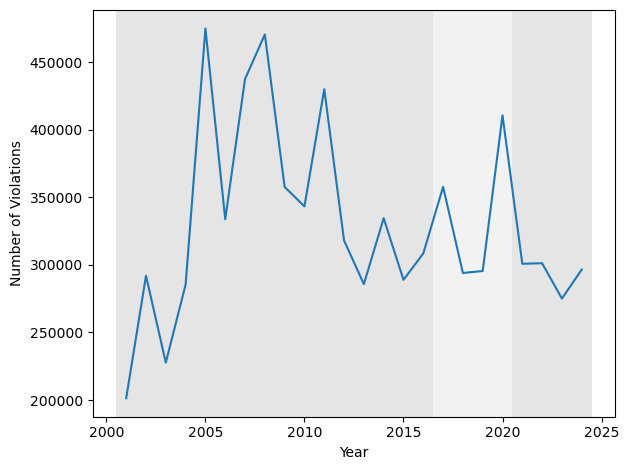

In [38]:
# make a plot of violations by year
sns.lineplot(data=pws_viols.groupby(['Year']).count(), x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.2, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Number of Violations')
#plt.savefig('num_viols_by_year.png')

## Type of violations by year

In [39]:
# group violations by type and year
pws_viols_type = pws_viols.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()
pws_viols_type

,Year,VIOLATION_CATEGORY_CODE,VIOLATION_ID
0,2001,Maximum Contaminant Level Violation,25954
1,2001,Monitoring and Reporting,161689
2,2001,Other Violation,10543
3,2001,Treatment Technique Violation,3199
4,2002,Maximum Contaminant Level Violation,28697
...,...,...,...
134,2024,Monitoring Violation,61941
135,2024,Monitoring and Reporting,146270
136,2024,Other Violation,30807
137,2024,Reporting Violation,16843


In [40]:
# make an array of the violation types
viol_types = pws_viols_type['VIOLATION_CATEGORY_CODE'].unique()
viol_types

array(['Maximum Contaminant Level Violation', 'Monitoring and Reporting',
       'Other Violation', 'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level', 'Monitoring Violation',
       'Reporting Violation'], dtype=object)

In [41]:
# there are 7 violation types but they aren't consistent over the years
# create a dictionary of violation categories with values over the years
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Maximum Contaminant Level Violation': array([25954, 28697, 33143, 40885, 55114, 56923, 59337, 59685, 57182,
        55250, 53432, 50805, 50240, 51191, 55032, 35993, 31416, 30530,
        30292, 26561, 24245, 22723, 21409, 18650]),
 'Monitoring and Reporting': array([161689, 244376, 169648, 218315, 390654, 249033, 347950, 381375,
        272248, 259261, 346828, 234225, 206518, 251881, 199081, 169217,
        217093, 157057, 160133, 281100, 168485, 170213, 141842, 146270]),
 'Other Violation': array([10543, 15701, 20867, 21143, 21708, 20074, 23381, 24041, 23430,
        23494, 23741, 26887, 22575, 24145, 24895, 32639, 27715, 24199,
        24276, 25125, 25485, 25996, 29877, 30807]),
 'Treatment Technique Violation': array([ 3199,  3203,  4033,  5033,  7260,  7646,  6769,  5271,  4722,
         5232,  5919,  6069,  6444,  7254,  9161, 14626, 14609, 15528,
        15337, 12118, 14287, 14853, 14757, 21977]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  83,   6,   6,  31,

Text(0, 0.5, 'Number of Violations')

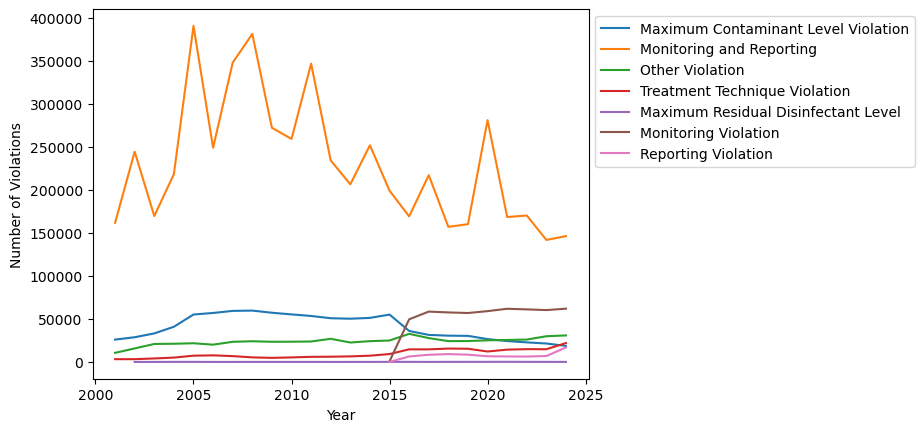

In [42]:
# take a look at the change over time
sns.lineplot(data=pws_viols_type, x='Year', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')

In [43]:
# maximum residual disinfectant level appears in 2002 and is consistently negligibly low
# in 2015 monitoring and reporting violation categories appear
# the monitoring category is a relatively low but non-negligible number
# lump these 2 categories with the M&R category

In [44]:
# map the new category values
# use a copy of the pws_viols df because I'm about to drop data and also not sure the significance of the M&R coding
pws_viols_copy = pws_viols.copy(deep=True) # this is a deep copy
pws_viols_copy = pws_viols_copy.replace(['Monitoring Violation','Reporting Violation'],['Monitoring and Reporting','Monitoring and Reporting'])
viol_types = pws_viols_copy['VIOLATION_CATEGORY_CODE'].unique()
viol_types

C:\Users\jenni\AppData\Local\Temp\ipykernel_43712\2076428083.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pws_viols_copy = pws_viols_copy.replace(['Monitoring Violation','Reporting Violation'],['Monitoring and Reporting','Monitoring and Reporting'])


array(['Monitoring and Reporting', 'Treatment Technique Violation',
       'Maximum Contaminant Level Violation', 'Other Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

In [45]:
# regroup violations by type and year
pws_viols_type = pws_viols_copy.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False)[['VIOLATION_ID']].count()

In [46]:
# new dictionary of violation counts
viol_counts = dict()
for viol_type in viol_types:
    array = np.array(pws_viols_type[pws_viols_type['VIOLATION_CATEGORY_CODE'] == viol_type]['VIOLATION_ID'])
    viol_counts.update({viol_type: array})
viol_counts

{'Monitoring and Reporting': array([161689, 244376, 169648, 218315, 390654, 249033, 347950, 381375,
        272248, 259261, 346828, 234225, 206518, 251881, 199793, 225112,
        283930, 223678, 225473, 346695, 236664, 237552, 208977, 225054]),
 'Treatment Technique Violation': array([ 3199,  3203,  4033,  5033,  7260,  7646,  6769,  5271,  4722,
         5232,  5919,  6069,  6444,  7254,  9161, 14626, 14609, 15528,
        15337, 12118, 14287, 14853, 14757, 21977]),
 'Maximum Contaminant Level Violation': array([25954, 28697, 33143, 40885, 55114, 56923, 59337, 59685, 57182,
        55250, 53432, 50805, 50240, 51191, 55032, 35993, 31416, 30530,
        30292, 26561, 24245, 22723, 21409, 18650]),
 'Other Violation': array([10543, 15701, 20867, 21143, 21708, 20074, 23381, 24041, 23430,
        23494, 23741, 26887, 22575, 24145, 24895, 32639, 27715, 24199,
        24276, 25125, 25485, 25996, 29877, 30807]),
 'Maximum Residual Disinfectant Level': array([  4,   3,  62,  83,   6,   6,  31,

In [47]:
# compare array lengths to make sure they are all equal
print(len(viol_counts['Maximum Contaminant Level Violation']))
print(len(viol_counts['Other Violation']))
print(len(viol_counts['Monitoring and Reporting']))
print(len(viol_counts['Treatment Technique Violation']))
print(len(viol_counts['Maximum Residual Disinfectant Level']))

24
24
24
24
23


In [48]:
# Maximum Residual Disinfectant Level violation count was zero in 2001
# need to add a zero value at the beginning of the array 
counts = list(viol_counts['Maximum Residual Disinfectant Level'])
counts.insert(0,0)
np.array(counts)
viol_counts['Maximum Residual Disinfectant Level'] = counts
len(viol_counts['Maximum Residual Disinfectant Level'])

24

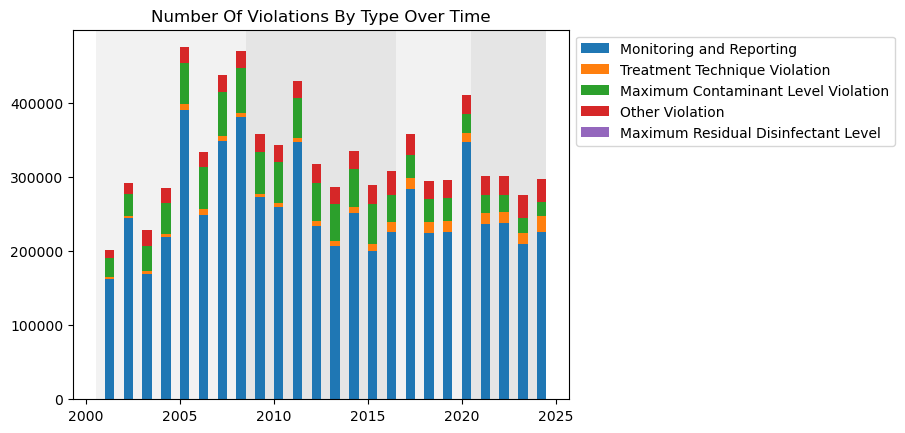

In [49]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for viol_type, viol_count in viol_counts.items():
    p = ax.bar(years, viol_count, width, label=viol_type, bottom=bottom, align='edge', zorder=1)
    bottom += viol_count

ax.set_title("Number Of Violations By Type Over Time")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('num_viols_type.png', bbox_inches='tight')
plt.show()

In [50]:
# can all categories be health-based?
can_they = pws_viols.groupby(['Year', 'VIOLATION_CATEGORY_CODE', 'IS_HEALTH_BASED_IND'], as_index=False)[['VIOLATION_ID']].count()
can_they[can_they['IS_HEALTH_BASED_IND'] == 'Y']['VIOLATION_CATEGORY_CODE'].unique()

array(['Maximum Contaminant Level Violation',
       'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

In [51]:
# answer is no, health-based violations are MCL, TT, and max residual disinfectant level

## Percentage of violations that were health-based by year

Text(46.972222222222214, 0.5, 'Percent Violations Health-Based')

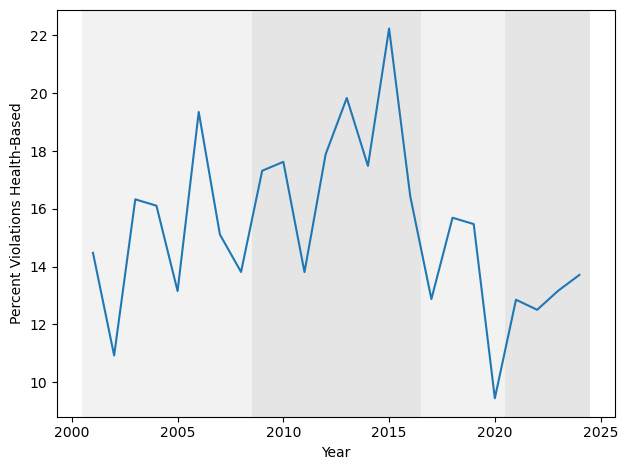

In [52]:
per_health_based = pd.DataFrame((pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y'] / (pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'Y']+pws_viols.groupby(['Year', 'IS_HEALTH_BASED_IND'])[['VIOLATION_ID']].count()['VIOLATION_ID'][:,'N'])) * 100)
sns.lineplot(data=per_health_based, x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Percent Violations Health-Based')
#plt.savefig('per_viols_health_by_year.png')


## Number of health-based violations by category by year

In [53]:
health_cat = pws_viols_health.groupby(['Year', 'VIOLATION_CATEGORY_CODE'], as_index=False).count()
health_cat['VIOLATION_CATEGORY_CODE'].unique()

array(['Maximum Contaminant Level Violation',
       'Treatment Technique Violation',
       'Maximum Residual Disinfectant Level'], dtype=object)

Text(0, 0.5, 'Number of Violations')

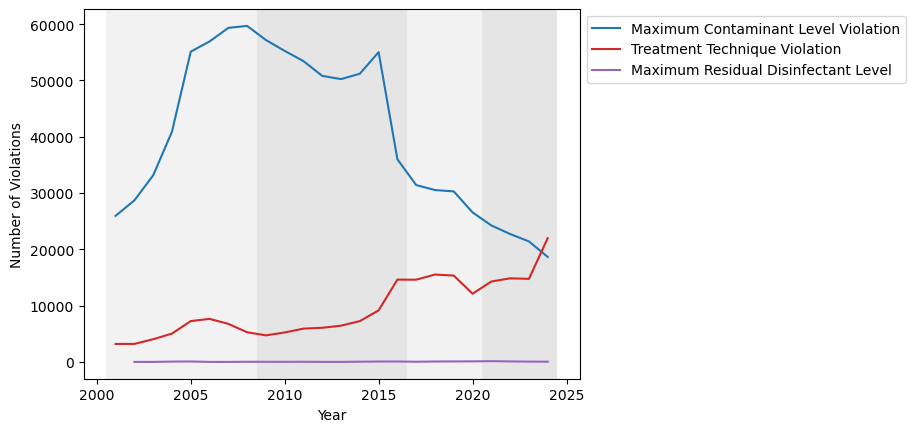

In [54]:
# make a plot of violation categories by year
sns.lineplot(data=health_cat, x='Year', y='VIOLATION_ID', hue='VIOLATION_CATEGORY_CODE', palette=['tab:blue','tab:red','tab:purple'])

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Violations')
#plt.savefig('num_health_viols_by_cat.png', bbox_inches='tight')

## Number of health-based violations  by year

Text(20.347222222222214, 0.5, 'Number of Health-Based Violations')

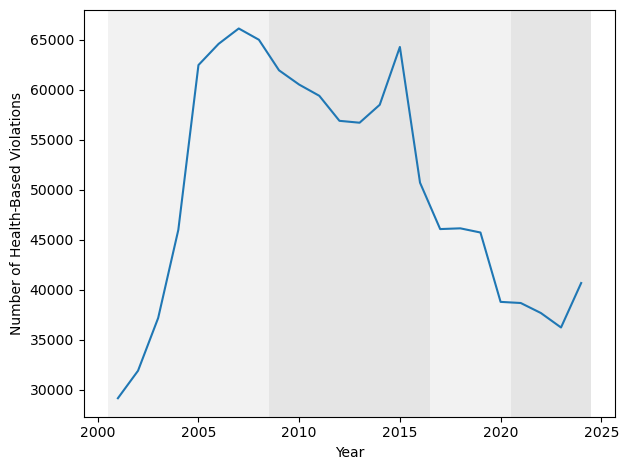

In [55]:
# make a plot of violation categories by year
sns.lineplot(data=pws_viols_health.groupby(['Year']).count(), x='Year', y='VIOLATION_ID')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Number of Health-Based Violations')
#plt.savefig('num_h_viols_by_year.png')

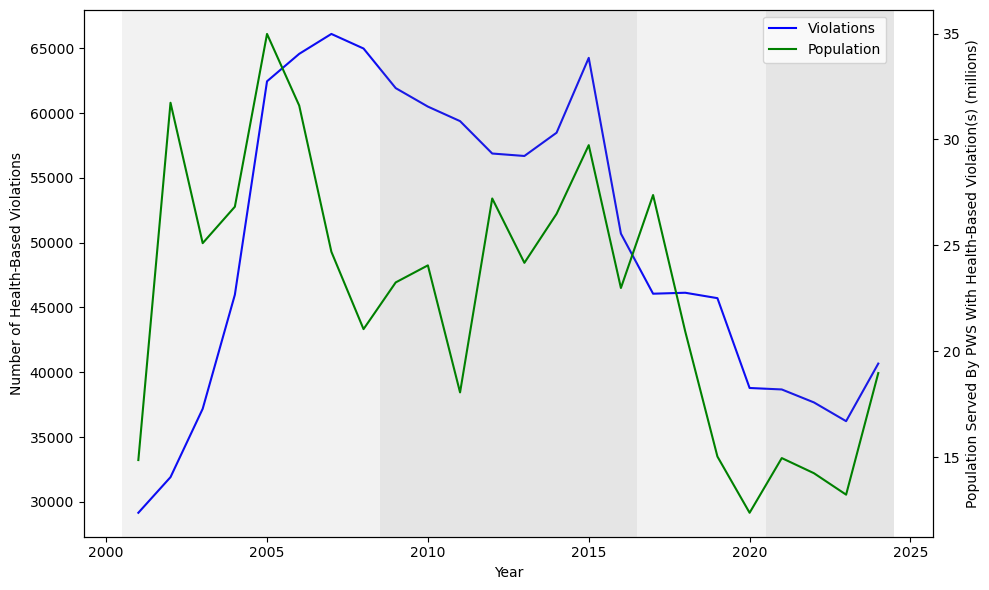

In [56]:
# how many people are affected by health-based violations?
viols_health_pop = pws_viols_health.groupby(['Year','PWSID'], as_index=False).count()[['Year','PWSID']]
viols_health_pop = viols_health_pop.merge(sdwa_pws, on=['PWSID'])[['Year','PWSID','POPULATION_SERVED_COUNT']]
viols_health_pop = viols_health_pop.groupby(['Year'], as_index=False).sum()[['Year','POPULATION_SERVED_COUNT']]

# plot population affected by health-based violations per year 

fig, ax1 = plt.subplots(figsize=(10,6))
sns.lineplot(data=pws_viols_health.groupby(['Year']).count(), x='Year', y='VIOLATION_ID', ax=ax1, color='blue')
ax1.set_ylabel('Number of Health-Based Violations')

ax2 = ax1.twinx()
sns.lineplot(data=viols_health_pop, x='Year', y='POPULATION_SERVED_COUNT', ax=ax2, color='green')
ax2.set_ylabel('Population Served')
def ticklabel(x, pos):
    return f'{x/1000000:g}'
ax2.yaxis.set_major_formatter(FuncFormatter(ticklabel))


# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Population Served By PWS With Health-Based Violation(s) (millions)')
plt.legend(handles=[Line2D([], [], color='blue', label='Violations'), Line2D([], [], color='green', label='Population')], loc=(0.8,0.9))
plt.savefig('pop_served_h_viol.png')

## Number of health-based violations by rule by year

In [57]:
health_rule = pws_viols_health.groupby(['Year', 'RULE_CODE'], as_index=False).count().rename(columns={'VIOLATION_ID':'num_viols_rule'})[['Year','RULE_CODE','num_viols_rule']]
health_rule['RULE_CODE'].unique()

array(['Arsenic Rule', 'Former Total Trihalomethane Rule',
       'Inorganic Chemicals',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Lead and Copper Rule', 'Nitrate Rule',
       'Radionuclides and Revised Rad Rule',
       'Surface Water Treatment Rule', 'Synthetic Organic Chemicals',
       'Total Coliform Rule', 'Volatile Organic Chemicals',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Long Term 2 Enhanced Surface Water Treatment Rule',
       'Ground Water Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Lead and Copper Rule Revisions', 'Revised Total Coliform Rule'],
      dtype=object)

In [58]:
health_rule

,Year,RULE_CODE,num_viols_rule
0,2001,Arsenic Rule,70
1,2001,Former Total Trihalomethane Rule,265
2,2001,Inorganic Chemicals,321
3,2001,Interim and Long Term 1 Enhanced Surface Water...,2
4,2001,Lead and Copper Rule,483
...,...,...,...
311,2024,Stage 1 Disinfectants and Disinfection Byprodu...,1280
312,2024,Stage 2 Disinfectants and Disinfection Byprodu...,9056
313,2024,Surface Water Treatment Rule,936
314,2024,Synthetic Organic Chemicals,46


In [59]:
# look at top 5 by year
# define a function to return top 5 violation counts
def year_top(df, n=5, column='num_viols_rule'):
  return df.sort_values(column, ascending=False)[:n]
# group by year and apply this function
health_rule_top = health_rule.groupby('Year').apply(year_top, include_groups=False)[['RULE_CODE','num_viols_rule']]

In [60]:
#health_rule_top.iloc[100:120]
health_rule_top

RULE_CODE  num_viols_rule
Year                                                                       
2001 9                                  Total Coliform Rule           22059
     7                         Surface Water Treatment Rule            2714
     5                                         Nitrate Rule            1785
     6                   Radionuclides and Revised Rad Rule            1335
     4                                 Lead and Copper Rule             483
...                                                     ...             ...
2024 312  Stage 2 Disinfectants and Disinfection Byprodu...            9056
     306                     Lead and Copper Rule Revisions            8836
     310                        Revised Total Coliform Rule            6130
     302                                  Ground Water Rule            3884
     308                                       Nitrate Rule            2715

[120 rows x 2 columns]

In [61]:
health_rule_top['RULE_CODE'].value_counts()

RULE_CODE
Radionuclides and Revised Rad Rule                               21
Nitrate Rule                                                     18
Arsenic Rule                                                     17
Total Coliform Rule                                              15
Stage 1 Disinfectants and Disinfection Byproducts Rule           12
Stage 2 Disinfectants and Disinfection Byproducts Rule           11
Ground Water Rule                                                10
Revised Total Coliform Rule                                       9
Surface Water Treatment Rule                                      4
Lead and Copper Rule                                              1
Interim and Long Term 1 Enhanced Surface Water Treatment Rule     1
Lead and Copper Rule Revisions                                    1
Name: count, dtype: int64

Text(50.722222222222186, 0.5, 'Rule Code')

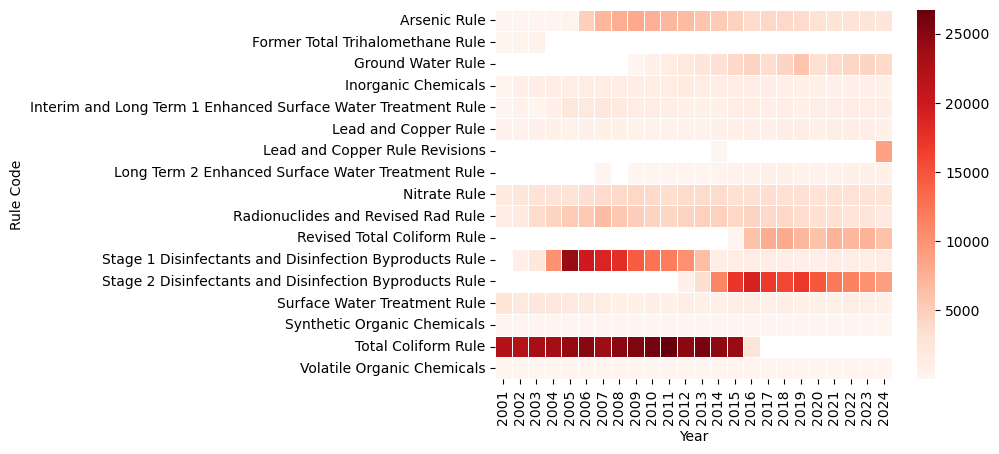

In [62]:
# grid plot of health-based violations
health_rule_reformat = (health_rule.pivot(index='RULE_CODE', columns='Year', values='num_viols_rule'))
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Rule Code')
#plt.savefig('num_health_viols_by_rule_heat.png', bbox_inches='tight')

In [63]:
# calculate values as a percentage
for year in range(2001,2025):
    health_rule_reformat[year] = (health_rule_reformat[year] / num_viols_health[year]) * 100

In [64]:
# num_viols[2001]
# health_rule_top.loc[2001]
health_rule_reformat

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Arsenic Rule,0.240113,0.329112,0.244762,0.302305,0.616424,7.447154,10.616832,12.039331,13.294042,12.447111,...,7.181203,7.605673,8.894533,8.823912,8.099654,7.930901,7.491208,7.650447,7.130632,5.928348
Former Total Trihalomethane Rule,0.908997,1.216148,1.457812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ground Water Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227676,1.381727,...,6.294250,8.935087,7.891537,9.294260,12.647097,8.608998,9.885705,11.175705,11.837456,9.550272
Inorganic Chemicals,1.101087,3.131269,2.942521,2.740322,2.004579,1.952768,2.178122,2.135812,2.194413,2.538675,...,2.251614,2.508925,2.273023,2.121987,1.981714,2.330798,2.128155,2.221868,2.263693,1.667117
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,0.006860,1.538992,0.777321,1.439756,3.197400,3.066202,3.171890,2.652838,2.289682,2.256049,...,2.217381,2.923135,2.081976,2.557656,1.990463,2.820678,3.190939,3.533222,3.497681,2.970321
Lead and Copper Rule,1.656776,1.554664,1.877404,1.663767,0.848584,1.141309,1.293260,0.969425,1.010819,0.889197,...,1.137478,1.901418,1.873562,2.412433,2.364495,2.186412,3.136636,3.241220,3.127761,1.991689
Lead and Copper Rule Revisions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.726622
Long Term 2 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,0.004538,NaN,0.025836,0.175195,...,0.694001,0.956626,1.484955,1.629964,1.349578,1.307206,1.380844,1.669719,1.907575,1.728589
Nitrate Rule,6.122869,7.572718,7.899621,6.135276,4.539123,5.203252,5.711520,6.019665,6.651058,6.452466,...,5.114759,6.453776,7.646216,7.180943,6.942561,7.796829,8.098883,8.178705,8.356338,6.675846


In [65]:
health_rule_reformat.index

Index(['Arsenic Rule', 'Former Total Trihalomethane Rule', 'Ground Water Rule',
       'Inorganic Chemicals',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Lead and Copper Rule', 'Lead and Copper Rule Revisions',
       'Long Term 2 Enhanced Surface Water Treatment Rule', 'Nitrate Rule',
       'Radionuclides and Revised Rad Rule', 'Revised Total Coliform Rule',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Surface Water Treatment Rule', 'Synthetic Organic Chemicals',
       'Total Coliform Rule', 'Volatile Organic Chemicals'],
      dtype='object', name='RULE_CODE')

In [66]:
health_rule_top['RULE_CODE'].unique()

array(['Total Coliform Rule', 'Surface Water Treatment Rule',
       'Nitrate Rule', 'Radionuclides and Revised Rad Rule',
       'Lead and Copper Rule',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
       'Arsenic Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Ground Water Rule', 'Revised Total Coliform Rule',
       'Lead and Copper Rule Revisions'], dtype=object)

In [67]:
# look at percentages for only those rules in top 5 (ever)
health_rule_reformat.loc[health_rule_top['RULE_CODE'].unique()]

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Total Coliform Rule,75.666312,69.010155,62.543371,50.987386,38.624974,38.762679,35.886072,38.193793,40.980139,43.045088,...,37.423170,5.019823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Surface Water Treatment Rule,9.309505,6.036861,5.686006,4.721618,2.758698,2.806039,2.217449,1.412590,1.437106,1.740381,...,1.903058,2.603602,2.071122,2.364748,2.036397,2.390099,2.394497,3.145656,2.650177,2.301507
Nitrate Rule,6.122869,7.572718,7.899621,6.135276,4.539123,5.203252,5.711520,6.019665,6.651058,6.452466,...,5.114759,6.453776,7.646216,7.180943,6.942561,7.796829,8.098883,8.178705,8.356338,6.675846
Radionuclides and Revised Rad Rule,4.579289,5.851931,9.951855,9.621575,8.482636,8.552846,9.905917,8.634034,8.028419,7.460664,...,6.493426,8.473540,8.749077,8.875932,7.867798,8.451721,8.179044,7.140771,6.978799,4.558755
Lead and Copper Rule,1.656776,1.554664,1.877404,1.663767,0.848584,1.141309,1.293260,0.969425,1.010819,0.889197,...,1.137478,1.901418,1.873562,2.412433,2.364495,2.186412,3.136636,3.241220,3.127761,1.991689
Stage 1 Disinfectants and Disinfection Byproducts Rule,NaN,3.131269,6.065252,21.903001,38.498487,30.654278,28.586338,27.503962,23.402228,20.826722,...,2.245390,2.497091,2.952542,2.486128,2.104204,2.596365,3.413322,2.893472,3.343087,3.147360
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,0.006860,1.538992,0.777321,1.439756,3.197400,3.066202,3.171890,2.652838,2.289682,2.256049,...,2.217381,2.923135,2.081976,2.557656,1.990463,2.820678,3.190939,3.533222,3.497681,2.970321
Arsenic Rule,0.240113,0.329112,0.244762,0.302305,0.616424,7.447154,10.616832,12.039331,13.294042,12.447111,...,7.181203,7.605673,8.894533,8.823912,8.099654,7.930901,7.491208,7.650447,7.130632,5.928348
Stage 2 Disinfectants and Disinfection Byproducts Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.672372,37.513560,36.542052,34.315935,37.081675,37.764600,31.361192,30.458443,27.956603,22.267575


In [68]:
#health_rule_reformat.idxmax()
health_rule_reformat[health_rule_reformat==health_rule_reformat.max()]

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
RULE_CODE,,,,,,,,,,,,,,,,,,,,,
Arsenic Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Former Total Trihalomethane Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ground Water Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inorganic Chemicals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interim and Long Term 1 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lead and Copper Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lead and Copper Rule Revisions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Long Term 2 Enhanced Surface Water Treatment Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nitrate Rule,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# export results
#health_rule_reformat.to_csv('health_rule_top.csv')

In [70]:
# do the percentages add up to 100?
health_rule_reformat.sum()

Year
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
2024    100.0
dtype: float64

Text(50.722222222222186, 0.5, 'Percentage of Violations by Rule Code')

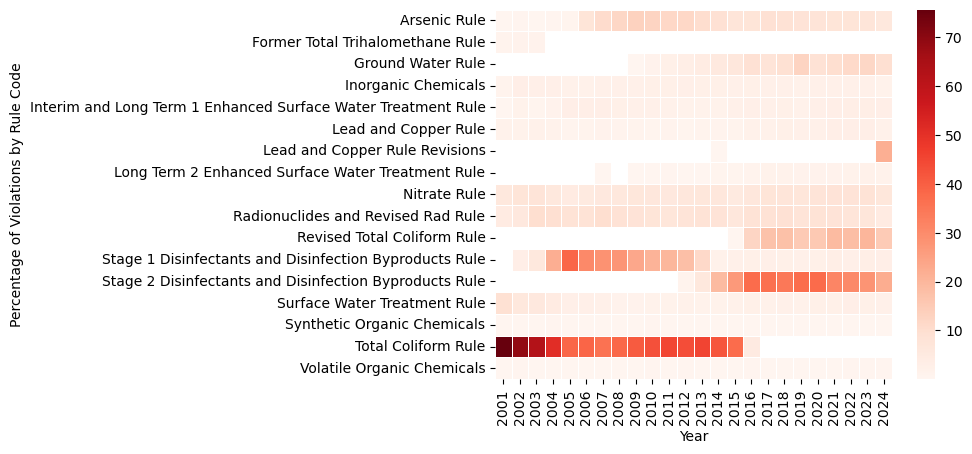

In [71]:
# grid plot (all rules)
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Percentage of Violations by Rule Code')
#plt.savefig('per_health_viols_by_rule.png', bbox_inches='tight')

In [72]:
# reorder index so rules with phases/stages are grouped side by side
health_rule_reformat = health_rule_reformat.reindex(['Arsenic Rule', 
                                                     'Former Total Trihalomethane Rule', 
                                                     'Stage 1 Disinfectants and Disinfection Byproducts Rule',
                                                     'Stage 2 Disinfectants and Disinfection Byproducts Rule',
                                                     'Ground Water Rule',
                                                     'Inorganic Chemicals',
                                                     'Lead and Copper Rule',
                                                     'Lead and Copper Rule Revisions',
                                                     'Nitrate Rule',
                                                     'Radionuclides and Revised Rad Rule', 
                                                     'Surface Water Treatment Rule',
                                                     'Interim and Long Term 1 Enhanced Surface Water Treatment Rule',
                                                     'Long Term 2 Enhanced Surface Water Treatment Rule',  
                                                     'Synthetic Organic Chemicals',
                                                     'Total Coliform Rule', 
                                                     'Revised Total Coliform Rule', 
                                                     'Volatile Organic Chemicals'])

Text(50.722222222222186, 0.5, 'Percentage of Violations by Rule Code')

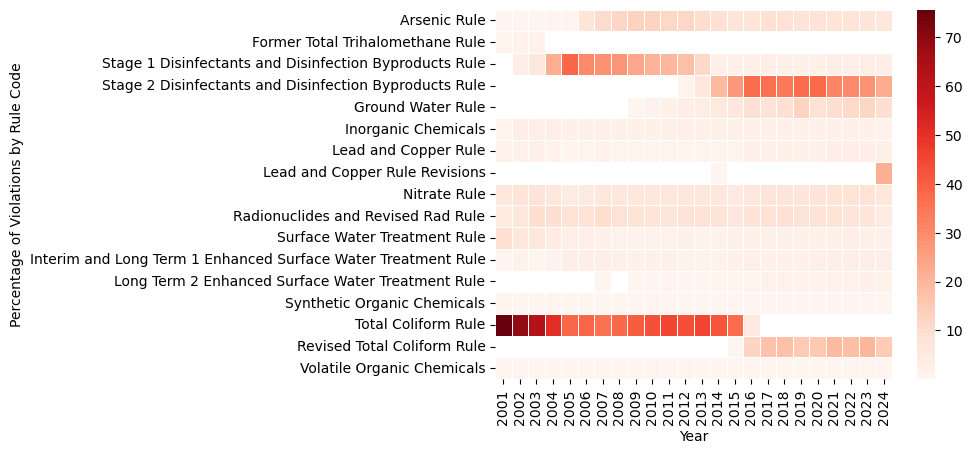

In [73]:
# grid plot (all rules)
sns.heatmap(health_rule_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Percentage of Violations by Rule Code')
#plt.savefig('per_health_viols_by_rule_ordered.png', bbox_inches='tight')

# Enforcement Analysis

## Enforcement action types

In [74]:
# number of enforcement actions by type for all violation types
viols_enf_type = pws_viols.groupby(['Year', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['Year', 'ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_type'})
viols_enf_type

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs_type
0,2001,Federal Bilateral Compliance Agreement signed,24
1,2001,Federal Civil Case filed,14
2,2001,Federal Complaint for Penalty Consent Order or...,6
3,2001,Federal Complaint for Penalty issued,138
4,2001,Federal Compliance Meeting conducted,2
...,...,...,...
1058,2024,State Unresolved,3
1059,2024,State Variance/Exemption issued,19
1060,2024,State Violation/Reminder Notice,69748
1061,2024,State no additional Formal Action needed,1757


Text(50.722222222222186, 0.5, 'Enforcement Action Type')

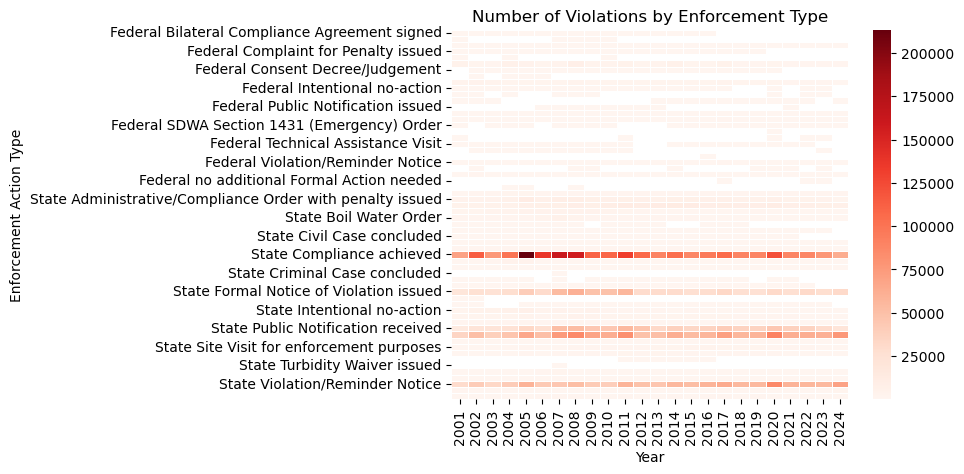

In [75]:
# plot using a heatmap
viols_enf_type_reformat = (viols_enf_type.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='num_enfs_type'))
sns.heatmap(viols_enf_type_reformat, linewidth=.5, cmap='Reds')
plt.title('Number of Violations by Enforcement Type')
plt.ylabel('Enforcement Action Type')

In [76]:
# most of the enforcement actions are only a few types
# narrow down to most common over the years

In [77]:
# filter the dataset for the top 10 action types from 2001-2024

# group the original viols df by enforcement type over all years
viols_enf_type_top10 = pws_viols.groupby(['ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['ENFORCEMENT_ACTION_TYPE_CODE','VIOLATION_ID']]

# list of the top 10 types
viols_enf_type_top10_vals = list(viols_enf_type_top10.sort_values(by='VIOLATION_ID',ascending=False).head(10)['ENFORCEMENT_ACTION_TYPE_CODE'])

# create a new viols df by filtering for only the top 10 enforcement types
viols_enf_type_top10 = pws_viols[pws_viols['ENFORCEMENT_ACTION_TYPE_CODE'].isin(viols_enf_type_top10_vals)]

# group this new df by year 
viols_enf_type_top10 = viols_enf_type_top10.groupby(['Year', 'ENFORCEMENT_ACTION_TYPE_CODE'], as_index=False).count()[['Year', 'ENFORCEMENT_ACTION_TYPE_CODE','ENFORCEMENT_ID',]].rename(columns={'ENFORCEMENT_ID':'num_enfs'})
viols_enf_type_top10

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs
0,2001,Federal Compliance achieved,4612
1,2001,Federal Final Administrative Order issued,3178
2,2001,State Administrative/Compliance Order with pen...,3670
3,2001,State Administrative/Compliance Order without ...,4402
4,2001,State Compliance achieved,69581
...,...,...,...
235,2024,State Formal Notice of Violation issued,30957
236,2024,State Intentional no-action,276
237,2024,State Public Notification received,20170
238,2024,State Public Notification requested,76209


In [78]:
viols_enf_type_top10_vals

['State Compliance achieved',
 'State Public Notification requested',
 'State Violation/Reminder Notice',
 'State Public Notification received',
 'State Formal Notice of Violation issued',
 'State Administrative/Compliance Order without penalty issued',
 'State Administrative/Compliance Order with penalty issued',
 'Federal Compliance achieved',
 'Federal Final Administrative Order issued',
 'State Intentional no-action']

Text(50.722222222222186, 0.5, 'Top 10 Enforcement Action Types')

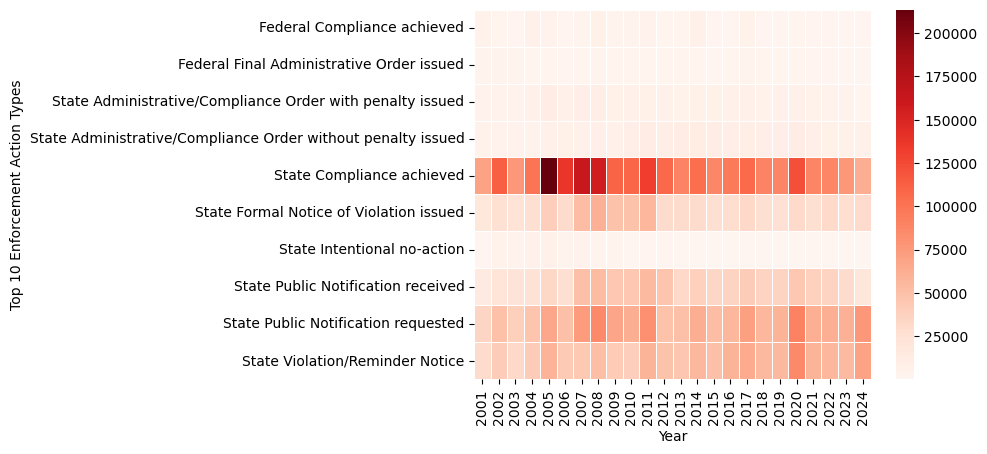

In [79]:
# plot heatmap
viols_enf_type_top10_reformat = (viols_enf_type_top10.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='num_enfs'))
sns.heatmap(viols_enf_type_top10_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('Top 10 Enforcement Action Types')

# most enforcements are resolved by states

## Enforcement frequency as a percentage

In [80]:
# create a dictionary of {year : total number of violations} 
num_viols_any_type = pws_viols.groupby(['Year']).count().rename(columns={'VIOLATION_ID':'num_viols_tot_yr'})['num_viols_tot_yr'].to_dict() 

# add a column for the total violations per year values
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['Year']
viols_enf_type_top10['yr_viols_tot'] = viols_enf_type_top10['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_type_top10['per_enfs'] = (viols_enf_type_top10['num_enfs']/viols_enf_type_top10['yr_viols_tot']) * 100
viols_enf_type_top10

,Year,ENFORCEMENT_ACTION_TYPE_CODE,num_enfs,yr_viols_tot,per_enfs
0,2001,Federal Compliance achieved,4612,201385,2.290141
1,2001,Federal Final Administrative Order issued,3178,201385,1.578072
2,2001,State Administrative/Compliance Order with pen...,3670,201385,1.822380
3,2001,State Administrative/Compliance Order without ...,4402,201385,2.185863
4,2001,State Compliance achieved,69581,201385,34.551233
...,...,...,...,...,...
235,2024,State Formal Notice of Violation issued,30957,296530,10.439753
236,2024,State Intentional no-action,276,296530,0.093077
237,2024,State Public Notification received,20170,296530,6.802010
238,2024,State Public Notification requested,76209,296530,25.700266


In [81]:
# check the total percentages - won't be 100% because we are only looking at top 10
viols_enf_type_top10.groupby('Year').sum()['per_enfs']

Year
2001    92.182139
2002    92.690278
2003    92.489921
2004    91.986351
2005    92.871178
2006    92.303750
2007    93.357992
2008    93.360161
2009    94.448111
2010    95.184977
2011    95.141783
2012    95.013742
2013    94.453892
2014    94.877628
2015    95.155267
2016    96.038580
2017    94.755484
2018    95.948138
2019    95.409978
2020    96.325666
2021    96.432097
2022    96.008552
2023    95.848814
2024    91.224834
Name: per_enfs, dtype: float64

In [82]:
# the top 10 enforcement types were responsible for an increasing proportion of violations over the years until 2023

Text(0.5, 1.0, 'Top 10 Enforcement Action Types as a Percentage of Violations')

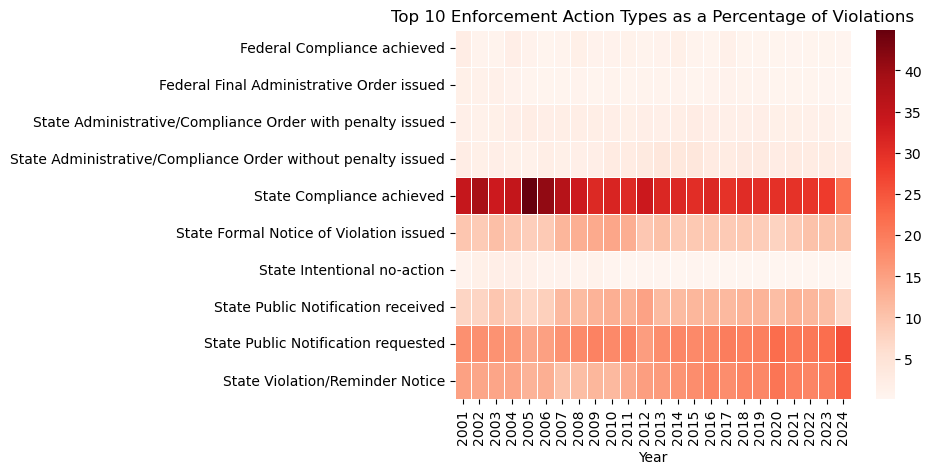

In [83]:
# plot heatmap
viols_enf_type_top10_reformat = (viols_enf_type_top10.pivot(index='ENFORCEMENT_ACTION_TYPE_CODE', columns='Year', values='per_enfs'))
sns.heatmap(viols_enf_type_top10_reformat, linewidth=.5, cmap='Reds')
plt.ylabel('')
plt.title('Top 10 Enforcement Action Types as a Percentage of Violations')
#plt.savefig('per_enf_by_type_top10_heat_corrected.png', bbox_inches='tight')

In [84]:
# "State Compliance achieved" is consistently the most common enforcement type but is never half or more of violations
viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('Year').max()['per_enfs']

Year
2001    34.551233
2002    38.856980
2003    33.439616
2004    34.833484
2005    44.960501
2006    41.009404
2007    36.836114
2008    33.482354
2009    30.970504
2010    31.775715
2011    30.829488
2012    33.712586
2013    31.456055
2014    31.133917
2015    30.268936
2016    31.247852
2017    29.652760
2018    30.475523
2019    30.123838
2020    29.736852
2021    29.581711
2022    29.290981
2023    28.150924
2024    21.117256
Name: per_enfs, dtype: float64

Text(0, 0.5, 'Percentage of Total')

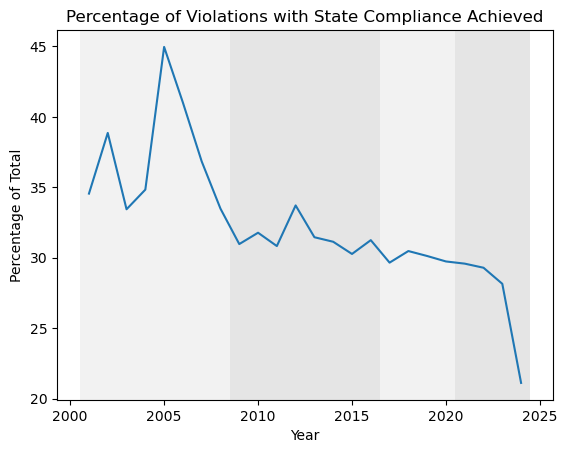

In [85]:
# plot percentage of violations with state compliance achieved by year
sns.lineplot(data=viols_enf_type_top10[viols_enf_type_top10['ENFORCEMENT_ACTION_TYPE_CODE']=='State Compliance achieved'].groupby('Year').max(), x='Year', y='per_enfs')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.tight_layout()
plt.title('Percentage of Violations with State Compliance Achieved')
plt.ylabel('Percentage of Total')
#plt.savefig('per_st_comp_ach_by_year.png')


## Enforcement action categories: Have systems come back into compliance?

In [86]:
# some values are null 
pws_viols[pws_viols['ENF_ACTION_CATEGORY'].isna() == True]['ENF_ACTION_CATEGORY']

4460408    NaN
4460409    NaN
4460410    NaN
4460411    NaN
4460412    NaN
          ... 
7933747    NaN
7933748    NaN
7933749    NaN
7933750    NaN
7933751    NaN
Name: ENF_ACTION_CATEGORY, Length: 106214, dtype: object

In [87]:
# add a 'None' category
pws_viols['ENF_ACTION_CATEGORY'] = pws_viols['ENF_ACTION_CATEGORY'].fillna(value='None')

# summarize violations by year and enforcement category
viols_enf_cat = pws_viols.groupby(['Year', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['Year', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})
viols_enf_cat


,Year,ENF_ACTION_CATEGORY,num_enfs_cat
0,2001,Formal,14349
1,2001,Informal,108559
2,2001,None,3615
3,2001,Resolving,74862
4,2002,Formal,15407
...,...,...,...
91,2023,Resolving,79288
92,2024,Formal,10397
93,2024,Informal,202494
94,2024,None,19829


In [88]:
# add a column for the total violations per year values
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['Year']
viols_enf_cat['yr_viols_tot'] = viols_enf_cat['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_enf_cat['per_enfs'] = (viols_enf_cat['num_enfs_cat']/viols_enf_cat['yr_viols_tot']) * 100
viols_enf_cat

,Year,ENF_ACTION_CATEGORY,num_enfs_cat,yr_viols_tot,per_enfs
0,2001,Formal,14349,201385,7.125158
1,2001,Informal,108559,201385,53.906200
2,2001,None,3615,201385,1.795069
3,2001,Resolving,74862,201385,37.173573
4,2002,Formal,15407,291981,5.276713
...,...,...,...,...,...
91,2023,Resolving,79288,275078,28.823825
92,2024,Formal,10397,296530,3.506222
93,2024,Informal,202494,296530,68.287863
94,2024,None,19829,296530,6.687013


In [89]:
# check the math
viols_enf_cat.groupby('Year').sum()['per_enfs']

Year
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
2021    100.0
2022    100.0
2023    100.0
2024    100.0
Name: per_enfs, dtype: float64

In [90]:
# create a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers = dict()
for enf_cat in enf_cats:
    array = np.array(viols_enf_cat[viols_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers.update({enf_cat:array})
enf_pers

{'Resolving': array([37.17357301, 40.26666119, 35.73524116, 38.08497817, 46.59396528,
        42.37927128, 38.51701822, 35.85181217, 32.85049551, 32.98180091,
        32.14568138, 34.74782543, 32.78432114, 33.12845839, 31.13551339,
        32.16307343, 31.37595854, 31.16392813, 30.97232517, 30.40440326,
        30.13719122, 29.94996996, 28.82382452, 21.51890197]),
 'Informal': array([53.90619957, 51.74446282, 55.87015907, 52.92252608, 45.09781622,
        49.08625578, 54.70244123, 56.83679738, 60.54338829, 60.16098631,
        61.43546256, 58.08380032, 59.52146011, 59.06168071, 60.98984956,
        61.31820392, 61.92134904, 62.36526956, 61.75715054, 63.41106416,
        63.82998527, 63.49300675, 64.55296316, 68.28786295]),
 'Formal': array([7.12515828, 5.27671321, 7.26501357, 7.2863459 , 6.33799406,
        6.46423841, 5.69468479, 5.89813415, 6.10668665, 6.57724925,
        5.79599583, 6.61081656, 7.18544645, 7.11213017, 7.52856001,
        5.9990274 , 5.74324797, 6.0449708 , 6.2311527

In [91]:
# What's the range? 
print("Max % of enforcements resolving:",enf_pers['Resolving'].max())
print("Min % of enforcements resolving:",enf_pers['Resolving'].min())

Max % of enforcements resolving: 46.5939652794012
Min % of enforcements resolving: 21.518901966074257


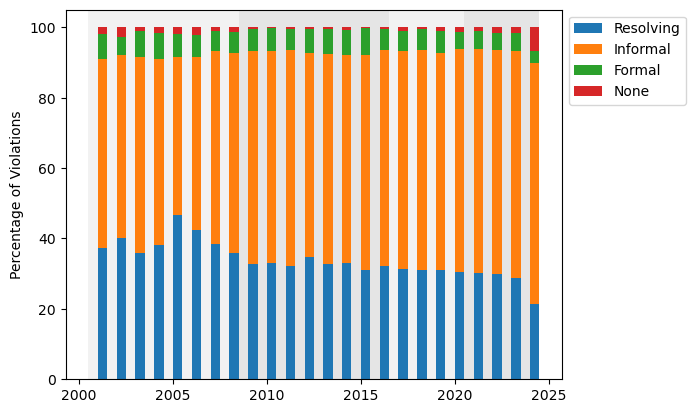

In [92]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('enf_cats_time.png', bbox_inches='tight')
plt.show()

## Enforcement action categories for health-based violations

In [93]:
# add a 'None' category
pws_viols_health['ENF_ACTION_CATEGORY'] = pws_viols_health['ENF_ACTION_CATEGORY'].fillna(value='None')

# look at enforcement category for health-based violations 
viols_health_enf_cat = pws_viols_health.groupby(['Year', 'ENF_ACTION_CATEGORY'], as_index=False).count()[['Year', 'ENF_ACTION_CATEGORY','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_enfs_cat'})

# add a column for the total violations per year values
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['Year']
viols_health_enf_cat['yr_viols_health'] = viols_health_enf_cat['yr_viols_health'].map(num_viols_health)

# calculate the percentages
viols_health_enf_cat['per_enfs'] = (viols_health_enf_cat['num_enfs_cat']/viols_health_enf_cat['yr_viols_health']) * 100
viols_health_enf_cat

# make a dictionary to plot the values as stacked bar chart
enf_cats = ['Resolving', 'Informal', 'Formal', 'None']
enf_pers_health = dict()
for enf_cat in enf_cats:
    array = np.array(viols_health_enf_cat[viols_health_enf_cat['ENF_ACTION_CATEGORY'] == enf_cat]['per_enfs'])
    enf_pers_health.update({enf_cat:array})
enf_pers_health

C:\Users\jenni\AppData\Local\Temp\ipykernel_43712\3470836203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pws_viols_health['ENF_ACTION_CATEGORY'] = pws_viols_health['ENF_ACTION_CATEGORY'].fillna(value='None')


{'Resolving': array([25.42105444, 26.2725677 , 25.8479249 , 25.08046977, 24.92274685,
        24.76345335, 24.80487657, 24.8895933 , 24.97981592, 25.35369562,
        24.51543371, 24.80573819, 24.43335156, 23.92839434, 23.62872481,
        22.71050711, 21.93348096, 21.25888677, 20.61113785, 19.76279489,
        18.48882913, 18.43062303, 17.04946996, 13.24350242]),
 'Informal': array([63.96597263, 64.47467402, 62.72627021, 60.96346237, 59.74350353,
        59.57878436, 59.94524443, 59.33802145, 58.53867269, 59.27541981,
        61.5428658 , 61.13357477, 61.84361385, 62.06507429, 61.99486501,
        61.34046036, 62.0923972 , 62.81428819, 62.78052408, 62.41846075,
        64.84019446, 65.5995328 , 67.81967756, 70.72708943]),
 'Formal': array([ 8.91503447,  7.36898195,  9.49729686, 11.7507612 , 13.78868662,
        14.58614015, 14.75980155, 15.32921969, 16.10366543, 15.26014809,
        13.83560952, 13.97981787, 13.62249308, 13.90223468, 14.26437408,
        15.84449397, 15.9307021 , 15.8

In [94]:
# What's the range?
print("Max % of health-based enforcements resolving:",enf_pers_health['Resolving'].max())
print("Min % of health-based enforcements resolving:",enf_pers_health['Resolving'].min())

Max % of health-based enforcements resolving: 26.272567703109328
Min % of health-based enforcements resolving: 13.243502421992181


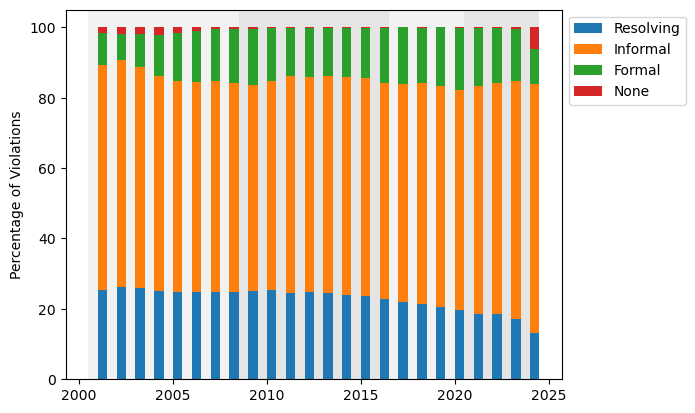

In [95]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for enf_cat, enf_per in enf_pers_health.items():
    p = ax.bar(years, enf_per, width, label=enf_cat, bottom=bottom, align='edge', zorder=1)
    bottom += enf_per

#ax.set_title("Violation Enforcement Categories Over Time, Health-Based Violations Only")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('enf_cats_health_time.png', bbox_inches='tight')
plt.show()

## Compare enforcement outcomes using 'ENF_ACTION_CATEGORY' and 'VIOLATION_STATUS' - Does the latter give us a different picture? 

In [96]:
# same process but use 'VIOLATION_STATUS' field instead of 'ENF_ACTION_CATEGORY'
viols_viol_stat = pws_viols.groupby(['Year', 'VIOLATION_STATUS'], as_index=False).count()[['Year', 'VIOLATION_STATUS','VIOLATION_ID',]].rename(columns={'VIOLATION_ID':'num_viols_stat'})

# add a column for the total violations per year values
viols_viol_stat['yr_viols_tot'] = viols_viol_stat['Year']
viols_viol_stat['yr_viols_tot'] = viols_viol_stat['yr_viols_tot'].map(num_viols_any_type)

# calculate the percentages
viols_viol_stat['per_viols_stat'] = (viols_viol_stat['num_viols_stat']/viols_viol_stat['yr_viols_tot']) * 100
viols_viol_stat

,Year,VIOLATION_STATUS,num_viols_stat,yr_viols_tot,per_viols_stat
0,2001,Addressed,48,201385,0.023835
1,2001,Archived,21657,201385,10.754028
2,2001,Resolved,179635,201385,89.199791
3,2001,Unaddressed,45,201385,0.022345
4,2002,Addressed,71,291981,0.024317
...,...,...,...,...,...
91,2023,Unaddressed,9878,275078,3.590981
92,2024,Addressed,2026,296530,0.683236
93,2024,Archived,95029,296530,32.047010
94,2024,Resolved,168657,296530,56.876876


In [97]:
# create a dictionary to plot the values as stacked bar chart
viol_stats = ['Resolved', 'Archived', 'Addressed', 'Unaddressed']
stat_pers = dict()
for viol_stat in viol_stats:
    array = np.array(viols_viol_stat[viols_viol_stat['VIOLATION_STATUS'] == viol_stat]['per_viols_stat'])
    stat_pers.update({viol_stat:array})
stat_pers

{'Resolved': array([89.19979144, 90.70350468, 92.13330171, 92.98972106, 94.77906318,
        93.73115721, 94.46853647, 94.58187979, 95.38572963, 95.36996845,
        95.338782  , 94.85619226, 93.93182311, 93.2929363 , 92.66385883,
        94.28594586, 92.72477195, 92.61189131, 91.22981585, 89.32063662,
        88.94192892, 87.04464194, 81.50633638, 56.87687586]),
 'Archived': array([10.75402835,  9.21669561,  7.76832064,  6.90798002,  5.16407305,
         6.13877884,  5.4125909 ,  5.31948138,  4.46298741,  4.30345599,
         4.3349025 ,  4.54882797,  5.47227646,  6.13189921,  6.63741162,
         4.99108445,  6.56487013,  6.26911055,  7.34802871,  9.42779557,
         8.98341539, 10.38247919, 14.0680098 , 32.04701042]),
 'Addressed': array([0.02383494, 0.02431665, 0.04304022, 0.02662575, 0.03159099,
        0.05574169, 0.08001042, 0.05102008, 0.09088164, 0.14158405,
        0.11187295, 0.18522362, 0.27153185, 0.27711927, 0.34884566,
        0.35953963, 0.34022258, 0.50541983, 0.66944

In [98]:
# This looks like a very different picture
# What's the range of resolved violations? 
print("Max % of violations resolved:",stat_pers['Resolved'].max())
print("Min % of violations resolved:",stat_pers['Resolved'].min())

Max % of violations resolved: 95.38572962573544
Min % of violations resolved: 56.876875864162145


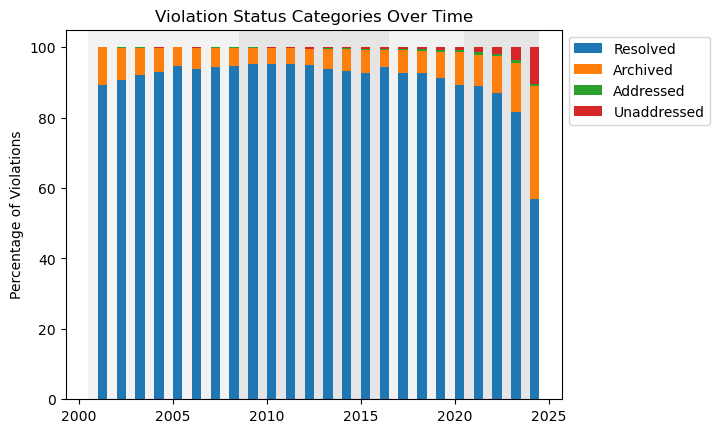

In [99]:
# plot the data
years = np.array(range(2001,2025))

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(len(years))

for viol_stat, stat_per in stat_pers.items():
    p = ax.bar(years, stat_per, width, label=viol_stat, bottom=bottom, align='edge', zorder=1)
    bottom += stat_per

ax.set_title("Violation Status Categories Over Time")
plt.ylabel("Percentage of Violations")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#plt.savefig('viol_stats_time.png', bbox_inches='tight')
plt.show()

This is a really different picture from the enforcement action categories

We see a drop-off in resolved violations through Trump 1 and Biden

We see an increase in 'Archived': The violation is not Resolved, but is more than five years past its noncompliance period end date. In keeping with the 
Enforcement Response Policy, the violation no longer contributes to the public water system's overall compliance status. Unresolved violations are also marked as Archived when a system ceases operations (becomes inactive).

Can't really see how this makes much sense, but there it is 

We also see an increase in 'Unaddressed': The violation is not Resolved or Archived, and has not been addressed by formal enforcement.

That's a more clear-cut drop-off in enforcement activity

## Violations & Enforcement by State

In [102]:
# aggregate the violations dataset by pws keeping state & year info
# count violations by pws
pws_viols_agg = pws_viols.groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_pws'})
pws_viols_agg

,STATE_CODE,PWSID,Year,num_viols_pws
0,AK,100211202,2002,5
1,AK,100211202,2003,3
2,AK,100211202,2004,9
3,AK,100211202,2005,8
4,AK,100211202,2006,15
...,...,...,...,...
687128,WY,WY5680251,2014,2
687129,WY,WY5680251,2017,1
687130,WY,WY5680251,2018,1
687131,WY,WY5680263,2017,1


In [103]:
# add resolving violations 
num_viols_res = pws_viols[pws_viols['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_pws_res'})
pws_viols_agg = pd.merge(pws_viols_agg, num_viols_res, on=['STATE_CODE', 'PWSID', 'Year'])

# add health-related violations
pws_viols_h_pws = pws_viols_health.groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h_pws'})
pws_viols_agg = pd.merge(pws_viols_agg, pws_viols_h_pws, on=['STATE_CODE', 'PWSID', 'Year'])

# add health-related violations resolving
num_viols_h_res = pws_viols_health[pws_viols_health['ENF_ACTION_CATEGORY']=='Resolving'].groupby(['STATE_CODE', 'PWSID', 'Year'], as_index=False)['VIOLATION_ID'].count().rename(columns={'VIOLATION_ID':'num_viols_h_pws_res'})
pws_viols_agg = pd.merge(pws_viols_agg, num_viols_h_res, on=['STATE_CODE', 'PWSID', 'Year'])
pws_viols_agg

,STATE_CODE,PWSID,Year,num_viols_pws,num_viols_pws_res,num_viols_h_pws,num_viols_h_pws_res
0,AK,100211202,2012,3,3,1,1
1,AK,100211202,2016,2,2,2,2
2,AK,100211202,2020,3,3,3,3
3,AK,100211202,2021,4,4,1,1
4,AK,100211202,2022,94,45,61,27
...,...,...,...,...,...,...,...
139104,WY,WY5680243,2021,3,3,2,2
139105,WY,WY5680243,2023,5,5,1,1
139106,WY,WY5680244,2003,9,3,9,3
139107,WY,WY5680244,2017,2,2,1,1


In [ ]:
# aggregate to state level
# mapping for renaming
col_names = {'num_viols_pws':'num_viols', 
             'num_viols_pws_res':'num_viols_res',
             'num_viols_h_pws':'num_viols_h',
             'num_viols_h_pws_res':'num_viols_h_res'            
            }
pws_viols_state = pws_viols_agg.groupby(['STATE_CODE','Year'], as_index=False).sum().drop(columns=['PWSID']).rename(columns=col_names)
pws_viols_state

In [ ]:
# add violation duration info
non_comp_dur = pws_viols.groupby(['STATE_CODE', 'Year'], as_index=False)['non_compl_duration'].mean()
non_comp_dur['avg_non_compl_dur'] = non_comp_dur['non_compl_duration'].dt.days
non_comp_dur = non_comp_dur.drop(columns=['non_compl_duration'])

# join the duration to the aggregated df
pws_viols_state = pd.merge(pws_viols_state, non_comp_dur, on=['STATE_CODE','Year'])
pws_viols_state

In [ ]:
# add health-based violation duration info
non_comp_dur_h = pws_viols_health.groupby(['STATE_CODE', 'Year'], as_index=False)['non_compl_duration'].mean()
non_comp_dur_h['avg_non_compl_h_dur'] = non_comp_dur_h['non_compl_duration'].dt.days
non_comp_dur_h = non_comp_dur_h.drop(columns=['non_compl_duration'])

# join the duration to the aggregated df
pws_viols_state = pd.merge(pws_viols_state, non_comp_dur_h, on=['STATE_CODE','Year'])
pws_viols_state

In [ ]:
# state averages over the entire time period
pws_viols_state_avgs = pws_viols_state.groupby('STATE_CODE').mean().drop(['Year'], axis=1)
# add a column for percent violations resolved
pws_viols_state_avgs['per_viols_res'] = (pws_viols_state_avgs['num_viols_res'] / pws_viols_state_avgs['num_viols']) * 100
# add a column for percent health based violations resolved
pws_viols_state_avgs['per_viols_h_res'] = (pws_viols_state_avgs['num_viols_h_res'] / pws_viols_state_avgs['num_viols_h']) * 100

In [ ]:
# add number of pws per state
num_pws_state = pws_viols_agg.groupby('STATE_CODE').count().rename(columns={'PWSID': 'num_pws'})['num_pws']
# merge with state averages
pws_viols_state_avgs = pd.merge(pws_viols_state_avgs, num_pws_state, on='STATE_CODE')
# calculate number of violations per pws 
pws_viols_state_avgs['num_viols_pws'] = pws_viols_state_avgs['num_viols'] / pws_viols_state_avgs['num_pws']
# calculate number of health-based violations per pws 
pws_viols_state_avgs['num_viols_h_pws'] = pws_viols_state_avgs['num_viols_h'] / pws_viols_state_avgs['num_pws']

In [ ]:
pws_viols_state_avgs

In [ ]:
# create fields for bivariate choropleth map (to be created in desktop GIS)


In [ ]:
# export state data for mapping in GIS
pws_viols_state_avgs.to_csv('pws_viols_state_avgs.csv')

In [ ]:
# look at some rankings and map results
# import state boundaries
file = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\boundaries\cb_2018_us_state_500k\cb_2018_us_state_500k.shp" # https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_bds = gpd.read_file(file)
state_bds = state_bds.rename(columns={'STUSPS':'STATE_CODE'})
# join violations stats to state boundaries
state_bds = state_bds.merge(pws_viols_state_avgs, on='STATE_CODE')

In [ ]:
### top 10 most violations per pws
pws_viols_state_avgs.sort_values('num_viols_pws', ascending=False)['num_viols_pws'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Violations Per PWS (2001-2024)')
#plt.savefig('num_viols_pws_bystate.png')#, bbox_inches='tight')
plt.show()

In [ ]:
### top 10 most health violations per pws
pws_viols_state_avgs.sort_values('num_viols_h_pws', ascending=False)['num_viols_h_pws'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='num_viols_h_pws', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Number of Health-Based Violations Per PWS (2001-2024)')
#plt.savefig('num_viols_h_pws_bystate.png', bbox_inches='tight')
plt.show()

In [ ]:
### top 10 longest noncompliance duration
pws_viols_state_avgs.sort_values('avg_non_compl_dur', ascending=False)['avg_non_compl_dur'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_dur', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Average Duration of Noncompliance (2001-2024)')
#plt.savefig('avg_dur_bystate.png', bbox_inches='tight')
plt.show()

In [ ]:
### top 10 longest health-based noncompliance duration
pws_viols_state_avgs.sort_values('avg_non_compl_h_dur', ascending=False)['avg_non_compl_h_dur'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='avg_non_compl_h_dur', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Average Duration of Noncompliance, Health-Based (2001-2024)')
#plt.savefig('avg_dur_bystate.png', bbox_inches='tight')
plt.show()

In [ ]:
### top 10 lowest percentage violations resolved
pws_viols_state_avgs.sort_values('per_viols_res', ascending=True)['per_viols_res'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_res', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Violations Resolved (2001-2024)')
#plt.savefig('per_viols_res_bystate.png', bbox_inches='tight')
plt.show()

In [ ]:
### top 10 lowest percentage health violations resolved
pws_viols_state_avgs.sort_values('per_viols_h_res', ascending=True)['per_viols_h_res'].head(10)

In [ ]:
# map
fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
ax.set_xlim([-124.725839, -66.949895])
ax.set_ylim([24.498131, 49.384358])

state_bds.plot(
    column='per_viols_h_res', 
    legend=True, 
    ax=ax, 
    cax=cax,
    legend_kwds={'orientation': 'horizontal'}
)

ax.set_axis_off()
plt.title('Percentage of Health-Based Violations Resolved (2001-2024)')
#plt.savefig('per_viols_h_res_bystate.png', bbox_inches='tight')
plt.show()

## State data over time

In [ ]:
# merge violations data aggregated to state/year (pws_viols_state) with number of pws per state (num_pws_state)
pws_viols_state_yrs = pd.merge(pws_viols_state, num_pws_state, on='STATE_CODE')

# create a new column for number of viols per pws by year
pws_viols_state_yrs['num_viols_pws'] = pws_viols_state_yrs['num_viols'] / pws_viols_state_yrs['num_pws']

# create a new column for number of health-based viols per pws by year
pws_viols_state_yrs['num_viols_h_pws'] = pws_viols_state_yrs['num_viols_h'] / pws_viols_state_yrs['num_pws']

# create a new column for percentage of violations resolved by year
pws_viols_state_yrs['per_viols_res'] = (pws_viols_state_yrs['num_viols_res'] / pws_viols_state_yrs['num_viols']) * 100

# create a new column for percentage of health-based violations resolved by year
pws_viols_state_yrs['per_viols_h_res'] = (pws_viols_state_yrs['num_viols_h_res'] / pws_viols_state_yrs['num_viols_h']) * 100

In [ ]:
pws_viols_state_yrs.head()

In [ ]:
# plot all 50 states over time
# num viols per pws per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='num_viols_pws')
sns.heatmap(heatmap_data, cmap='Reds')

In [ ]:
# you can see the hot moments for each state but there doesn't seem to be any overarching trend
# note the label font is too large so only some states are labeled

In [ ]:
#sns.lineplot(data=pws_viols_state_yrs, x='Year', y='num_viols_pws', hue='STATE_CODE')

In [ ]:
# num health-based viols per pws per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='num_viols_h_pws')
sns.heatmap(heatmap_data, cmap='Reds')

In [ ]:
# chronic problems become more apparent here
# a few states seem to have had 5-7 year stretches of chronic violations and 1 or 2 states have had longer stretches of chronic problems

In [ ]:
# percentage of violations resolved per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='per_viols_res')
sns.heatmap(heatmap_data, cmap='Reds')

In [ ]:
# some are high, some are low, not much change over time for most
# a few states are bimodal; that seems interesting

In [ ]:
# percentage of health-based violations resolved per year
heatmap_data = pws_viols_state_yrs.pivot(index='STATE_CODE', columns='Year', values='per_viols_h_res')
sns.heatmap(heatmap_data, cmap='Reds')

In [ ]:
# quite similar to previous

In [ ]:
pws_viols_state_yrs

# Site Visit Analysis

## Prep the site visit data

In [ ]:
# Load site visit data
file = r"C:\Users\jenni\Workspaces\Projects\edgi\soe_report\data\sdwa\SDWA_latest_downloads\SDWA_SITE_VISITS.csv"
visits = pd.read_csv(file)
# look at data fields
visits.columns

In [ ]:
# Map the visit reason codes 
reasons = sdwa_ref_codes.loc[sdwa_ref_codes["VALUE_TYPE"]=='VISIT_REASON_CODE'].set_index("VALUE_CODE")[["VALUE_DESCRIPTION"]].to_dict()["VALUE_DESCRIPTION"]
visits['VISIT_REASON_CODE'] = visits['VISIT_REASON_CODE'].astype(str).map(reasons)

# Map some other codes that aren't in the csv
# Map evaluation results categories
eval_results_dict = {'M':'Minor deficiencies',
                     'N':'No deficiencies or recommendations',
                     'R':'Recommendations made',
                     'S':'Significant deficiencies',
                     'X':'Not evaluated',
                     'Z':'Not applicable',
                     'D':'Sanitary defect'
                    }

evals = ['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE',
         'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE',
         'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']

for eval in evals:
    visits[eval] = visits[eval].astype(str).map(eval_results_dict)

# Map agencies
agency_dict = {'NULL':'Unknown Agency Type','AR':'Alaskan Remote Village','AT':'Authority','BR':'Borough',
               'CM':'Commission','CN':'County','CT':'City','DS':'District','FD':'Federal','MN':'Municipality',
               'NA':'Native American Tribe','PR':'Parish','RG':'Region','SA':'State Administrative District',
               'SD':'School District','SR':'State Administrative Region','ST':'State','TW':'Town','WD':'Water District',
               'SC':'State Contractor','TA':'Non-State Provider Engineering/Technical Assistance Firm','WS':'Water System'
              }
visits['AGENCY_TYPE_CODE'] = visits['AGENCY_TYPE_CODE'].astype(str).map(agency_dict)


In [ ]:
# Join the visits data to the filtered PWS df
pws_visits = sdwa_pws_active.merge(visits, on='PWSID')

# convert VISIT_DATE to datetime 
pws_visits['VISIT_DATE'] = pd.to_datetime(pws_visits['VISIT_DATE'], format='mixed')

# Filter visits to those occurring from 2001-2023
pws_visits = pws_visits[(pws_visits['VISIT_DATE']>'12-31-2000') & (pws_visits['VISIT_DATE']<'01-01-2025')]

# Add a column to record the site visit date year value only
pws_visits['Year'] = pws_visits['VISIT_DATE'].dt.year
pws_visits['Year'] = pws_visits['Year'].astype(int)

print(f'There were {len(pws_visits)} site visits at {len(pws_visits['PWSID'].unique())} water systemsfrom 2000-2024')

## Number of Site Visits Per Year

**Note** these are total visits, not number of PWS visited

In [ ]:
# Count site visits per year by PWS type 
# This is one place where there seemed to be a notable difference between CWS and other system types
# create a df of site visit counts grouped by year and system type
visits_by_year = pd.DataFrame(pws_visits.groupby(['Year','PWS_TYPE_CODE']).count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])

In [ ]:
# Format site visits per year for stacked bar chart
years = range(2001,2025)
visit_counts = {'CWS':[], 'NTNCWS':[], 'TNCWS':[]}

# loop through the years
for year in years:
    # append visit counts to corresponding lists
    visit_counts['CWS'].append(int(visits_by_year.loc[year,'CWS'].iloc[0]))
    visit_counts['NTNCWS'].append(int(visits_by_year.loc[year,'NTNCWS'].iloc[0]))
    visit_counts['TNCWS'].append(int(visits_by_year.loc[year,'TNCWS'].iloc[0]))

# convert lists to np arrays
visit_counts['CWS'] = np.array(visit_counts['CWS'])
visit_counts['NTNCWS'] = np.array(visit_counts['NTNCWS'])
visit_counts['TNCWS'] = np.array(visit_counts['TNCWS'])

In [ ]:
# plot the data
width = 0.5

plt.bar(years, visit_counts['CWS'], width, label='CWS')
plt.bar(years, visit_counts['NTNCWS'], width, bottom=visit_counts['CWS'], label='NTNCWS')
plt.bar(years, visit_counts['TNCWS'], width, bottom=visit_counts['CWS']+visit_counts['NTNCWS'], label='TNCWS')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

#ax.set_title("Number Of Site Visits By System Type")
plt.legend(bbox_to_anchor=(0,1), loc='upper left')

#plt.savefig('num_visits_type.png', bbox_inches='tight')
plt.show()

In [ ]:
# add the total number of visits per year
total_visits = pd.DataFrame(pws_visits.groupby('Year').count().rename(columns={'VISIT_ID':'num_visits'})['num_visits'])
total_visits['PWS_TYPE_CODE'] = 'Annual Total'
total_visits = total_visits.reset_index().set_index(['Year','PWS_TYPE_CODE'])
visits_with_tot = pd.concat([visits_by_year,total_visits])

In [ ]:
# make a plot of site visits by year with total
sns.lineplot(data=visits_with_tot, x='Year', y='num_visits', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Number of Site Visits')
#plt.savefig('num_visits_by_year.png')

## What percentage of PWS in each site type gets a visit each year?

In [ ]:
# group visits per pws by year
per_visits_year = pws_visits.groupby(['Year','PWS_TYPE_CODE','PWSID']).count().reset_index().rename(columns={'VISIT_ID':'num_visits'})[['Year','PWS_TYPE_CODE','PWSID','num_visits']]

# count pws visited per year
per_visits_year = per_visits_year.groupby(['Year','PWS_TYPE_CODE']).count().reset_index().rename(columns={'num_visits':'num_pws_visited'}).drop(columns='PWSID')

# add a column for percentage of pws visited
per_visits_year['per_pws_visited'] = per_visits_year.apply(lambda x: (x['num_pws_visited'] / int(sdwa_pws_active['PWS_TYPE_CODE'].value_counts()[x['PWS_TYPE_CODE']])*100), axis=1)

per_visits_year

In [ ]:
# plot the percentage data
sns.lineplot(data=per_visits_year, x='Year', y='per_pws_visited', hue='PWS_TYPE_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.legend(bbox_to_anchor=(0,1), loc='upper left')
plt.ylabel('Percentage of PWS With Site Visits')
#plt.savefig('per_visits_by_year.png')

## What types of visits are these and who is visiting? 

In [ ]:
# group visits by type and year
pws_visits_type = pws_visits.groupby(['Year', 'VISIT_REASON_CODE'], as_index=False).count().rename(columns={'VISIT_ID':'num_visits'})[['Year', 'VISIT_REASON_CODE', 'num_visits']]


In [ ]:
# take a look at the counts over time
sns.lineplot(data=pws_visits_type, x='Year', y='num_visits', hue='VISIT_REASON_CODE')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Number of Visits By Type')

In [ ]:
# So many types. One of them is much more common. 
pws_visits_type[pws_visits_type['num_visits'] == pws_visits_type['num_visits'].max()]

In [ ]:
# Sanitary surveys are more common than any other kind of visit
# Whats the type that becomes a little bit more common than the others around 2016?
pws_visits_type[pws_visits_type['Year']==2018].sort_values(by='num_visits',ascending=False).head(2)

In [ ]:
# 'Other' is not super informative

In [ ]:
# Who performed the site visits?
pws_visits.groupby('AGENCY_TYPE_CODE').count()['VISIT_ID'].sort_values(ascending=False)

In [ ]:
# Who performed the sanitary survey visits?
pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['AGENCY_TYPE_CODE']].value_counts()

In [ ]:
# Same pattern for visits overall and sanitary surveys -- the most common type:
# 1. Local authorities, particularly states, do the visits. Makes total sense.
# 2. The number of federal visits is *extremely* low.

### What were the outcomes of the sanitary visits?

Take sanitary survey visits as a subset since they were so much more common that other categories

In [ ]:
# Filter for sanitary survey visits (most common type) and outcome categories
outcomes_sanitary = pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE',
                                                                          'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE', 'OTHER_EVAL_CODE',
                                                                          'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE',
                                                                          'TREATMENT_EVAL_CODE', 'FINISHED_WATER_STOR_EVAL_CODE',
                                                                          'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']].apply(pd.Series.value_counts)
# a bit hard to make sense of as raw numbers instead of percentages, 
for col in outcomes_sanitary.columns:
    outcomes_sanitary[col] = (outcomes_sanitary[col] / outcomes_sanitary[col].sum()) * 100  


In [ ]:
# check the math
outcomes_sanitary.sum() 

In [ ]:
outcomes_sanitary # of sanitary survey visits

In [ ]:
outcomes_sanitary.transpose().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Outcomes of Sanitary Survey Visits')
#plt.savefig('san_visit_outcomes.png', bbox_inches='tight')

In [ ]:
# plot the sanitary visit outcomes as lines to get a clearer picture of individual trends
# focus on source water and treatment evaluation categories to start for simplicity - these are direct and clear

# Treatment: 'Identifies existing or potential sanitary risks by evaluating the design, operation, maintenance and management of water treatment plants.'
# Source: 'Reviews a raw water source’s features for the purposes of preventing potential contamination or water quality degradation.'

# https://www.epa.gov/dwreginfo/sanitary-surveys

In [ ]:
# Treatment inspection category outcomes
treatment_outcomes = pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['Year','TREATMENT_EVAL_CODE','PWSID']]
treatment_outcomes = treatment_outcomes.groupby(['Year','TREATMENT_EVAL_CODE'],as_index=False).count().rename(columns={'PWSID':'num_pws'})

sns.lineplot(data=treatment_outcomes, x='Year', y='num_pws', hue='TREATMENT_EVAL_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Sanitary Survey Outcomes for Treatment Inspection')
#plt.savefig('per_viols_health_by_year.png')


In [ ]:
# Source inspection category outcomes
source_outcomes = pws_visits[pws_visits['VISIT_REASON_CODE']=='Sanitary Survey, Complete'][['Year','SOURCE_WATER_EVAL_CODE','PWSID']]
source_outcomes = source_outcomes.groupby(['Year','SOURCE_WATER_EVAL_CODE'],as_index=False).count().rename(columns={'PWSID':'num_pws'})

sns.lineplot(data=source_outcomes, x='Year', y='num_pws', hue='SOURCE_WATER_EVAL_CODE')

# add the spans for presidential administrations
# bush
plt.axvspan(2000.5, 2008.5, facecolor='grey', alpha=0.1, zorder=-1)
# obama 
plt.axvspan(2008.5, 2016.5, facecolor='grey', alpha=0.2, zorder=-1)
# trump
plt.axvspan(2016.5, 2020.5, facecolor='grey', alpha=0.1, zorder=-1)
# biden
plt.axvspan(2020.5, 2024.5, facecolor='grey', alpha=0.2, zorder=-1)

plt.tight_layout()
plt.ylabel('Sanitary Survey Outcomes for Source Water Inspection')
#plt.savefig('per_viols_health_by_year.png')


### What types of inspections did the federal government do? What were the outcomes?

In [ ]:
# filter the visits df for federal only
pws_visits_federal = pws_visits[pws_visits['AGENCY_TYPE_CODE']=='Federal']

In [ ]:
# number of visits by year
pws_visits_federal.groupby('Year').count().rename(columns={'VISIT_ID':'num_visits'})['num_visits']

In [ ]:
# They seem to go on a three year cycle; plus 2007 & 2008

In [ ]:
# Filter for federal visits and outcome categories
outcomes_federal = pws_visits_federal[['MANAGEMENT_OPS_EVAL_CODE', 'SOURCE_WATER_EVAL_CODE', 'SECURITY_EVAL_CODE', 'PUMPS_EVAL_CODE', 
                                       'OTHER_EVAL_CODE', 'COMPLIANCE_EVAL_CODE', 'DATA_VERIFICATION_EVAL_CODE', 'TREATMENT_EVAL_CODE', 
                                       'FINISHED_WATER_STOR_EVAL_CODE', 'DISTRIBUTION_EVAL_CODE', 'FINANCIAL_EVAL_CODE']].apply(pd.Series.value_counts)
# calculate as percentages
for col in outcomes_federal.columns:
    outcomes_federal[col] = (outcomes_federal[col] / outcomes_federal[col].sum()) * 100  


In [ ]:
# plot the outcomes by evaluation type, over the entire time frame
outcomes_federal.transpose().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Outcomes of Federal Site Visits')

In [ ]:
# It might be more interesting to look at these federal visits in another way.

### How many PWS were active each year?

In [ ]:
# find the number of pws that were deactivated each year
num_pws_deac_year = pd.Series(sdwa_pws[sdwa_pws['PWS_ACTIVITY_CODE']=='I']['PWS_DEACTIVATION_DATE'], dtype='datetime64[ns]').dt.year
num_pws_deac_year = num_pws_deac_year.value_counts().sort_index(ascending=False)
num_pws_deac_year = num_pws_deac_year[num_pws_deac_year.index > 2001]
num_pws_deac_year

In [ ]:
# plot the number of systems deactivated in any given year
num_pws_deac_year.plot().set_xlabel('Number of Systems Deactivated')
# interesting spike in 2022

In [ ]:
# calculate the cumulative sum
num_pws_deac_cum = num_pws_deac_year.cumsum()
num_pws_deac_cum

In [ ]:
# add the cumulative sum to the number of currently active pws to get the total number of active pws per year
# we are adding 741 systems to the current year, which I take to mean that those systems were active in January
num_pws_year = num_pws_deac_cum + (len(sdwa_pws_active))
num_pws_year

In [ ]:
# plot the number of active systems per year
num_pws_year.plot().set_xlabel('Number of Active Systems')